In [13]:
# imports
# basic file i/o modules
import os
from pathlib import Path

# modules for data analysis
import pandas as pd
import datetime
import numpy as np

# pretty plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')

# Expected wait times at Burning Man

## Introduction

For (almost) every burner, their experience in Black Rock City is bookended by their passage through the city gates. Every year, the Burning Man organization makes their best efforts to mitigate traffic, including a twitter profile called ["Burining Man Traffic"](https://twitter.com/bmantraffic?), which provides status updates on the traffic status and estimated wait times from the highway (Hwy 447), nearest city (Gerlach), and along the city road (Gate). 

This year, in an attempt to avoid waiting 7 hours like I had to last year, I analyzed the wait times reported by @bmantraffic as a function of time, to see what were the best times to enter and leave the city. This analysis looked at average wait times reported throughout the course of Burning Man from 2015 - 2018. 

The figures below show average wait times with respect to the official start date of each year's burn. 

## Results

As expected, wait times are highest around when the gates open and when the event ends. 

### Entrance

In particular, I noticed that traffic delays begin a whole day before the event officially opens. For people with early access, it is of interest to arrive on the playa a full day or two before the gates open. If possible, waiting a whole day can reduce wait times, unless disrupted by an act of nature. For example, 2018 saw a major delay in gate entrance for several hours after opening due to a massive dust storm. Factors like these were not accounted for in this analysis.

### Exodus

Unsurprisingly, the highest wait times for exodus are seen at the end of the festival. Wait times are particularly high starting the last night, presumably after the man burns. Leaving before this 

![alt text](../fig_traffic-coarse.png)




## Methods
With help from some colleagues, we first mined all public tweets made by @bmtraffic.

### Raw data

The raw tweets were pre-processed in excel, courtesy of a colleague. They added some cell functions to parse the text in each tweet which a) checked if the word 'hour' was in the tweet and, if so, b) used regular expressions to pull out the nearest number preceding 'hour' (e.g. Expected traffic delays of up to 5 hours -> (a:True, b:5)). 

The following fields were produced as a result of this processing:
* created_at - datetime stamp for when tweet was generated
* Hours Wait - estimated hours wait, as parsed from tweet text
* Included 'Hour' - boolean whether tweet text mentions hour and thus (assumed) delay esimates
* Data_Year - year the tweet was made, assumed to correspond to that year's burn
* text - body of the tweet

In [14]:
# Load data
f_traffic_report = Path(os.path.join(os.path.abspath('..'), 'data/data_traffic-2019.xlsx'))

assert os.path.exists(f_traffic_report), print("Does not exist!: ", f_traffic_report)

df_traffic_raw = pd.read_excel(f_traffic_report)

print("First 3 samples of mined tweets")
print(df_traffic_raw.head(3))


First 3 samples of mined tweets
           created_at  Hours Wait  Includes 'Hour'  Data_Year  \
0 2014-08-21 15:44:56         0.0            False       2014   
1 2014-08-24 05:00:50         0.0            False       2014   
2 2014-08-24 05:04:03         0.0            False       2014   

                                                text  
0  Cattleguard repairs today on Hwy. 447. Expect ...  
1  Law enforcement is asking all burners to pleas...  
2  Washoe County Sheriff recommends against using...  


### Additional processing

Manual processing:
 - I reviewed each entry for errouneous estimates of wait time (e.g. '1.75 hours' parsed as 75 hours)
 
Computer processing:
 - Compute time stamps of each tweet relative to the official start date of Burning Man for that year
 

In [21]:
def get_start_dates():
    '''
    Returns manually constructed dictionary of the start dates of each burn from 2014-2018. 
    Start dates courtesy of google. 
    
    Parameters - n/a
    
    Returns
    -------
    dict_starts : dictionary
        Each key is a year, each item is a numpy datetime64 object denoting start day and hour. 
    '''

    dict_starts = dict()
    dict_starts[2014] = np.datetime64('2014-08-25 10:00:00')
    dict_starts[2015] = np.datetime64('2015-08-30 10:00:00')
    dict_starts[2016] = np.datetime64('2016-08-28 00:01:00')
    dict_starts[2017] = np.datetime64('2017-08-27 00:01:00')
    dict_starts[2018] = np.datetime64('2018-08-26 00:01:00')
    
    return dict_starts

def calculate_days_from_opening(df, fine=True):
    '''
    Calculates custom timestamp relative to when Burning Man started for the same year. 
    Score is a compound of the day and hours.
    Hours are on a percent scale 0: midnight, 0.99: 11:59pm
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame consisting of mined and processed tweets from @bmtraffic
    fine : boolean
        toggles whether hour score is binned into quarters or not.
        
    Returns:
    --------
    
    dt_diffs : array-like
        array of relative timestamps of each tweet
    
    '''
    
    # Initialize empty container
    dt_diffs = []
    
    # Get start dates of each year
    dict_starts = get_start_dates()
    
    # Iterate through each tweet
    for i, dat in df.iterrows():
        
        # Get tweet timestamp
        dt = dat['created_at']
        
        # Get start date of Gate open for the year
        dt_ref = dict_starts[dat['Data_Year']]
        
        # Calculate time difference 
        dt_diff = dt - dt_ref
        
        # Compute compound score
        val = dt_diff.days
        if fine: val += (dt_diff.seconds/60/60/24)
        else: val += int((dt_diff.seconds/60/60/24)*5) / 5.

        # update container
        dt_diffs.append(val)
        
    return dt_diffs



Processed fields;
* ts - custom time score = day + (hr / 24.)
* ts_coarse - custom time score, binned every 0.2 or ~5 hours; = day + round((hr / 24.)*5) / 5

In [23]:
df_traffic = df_traffic_raw.copy()
df_traffic['ts'] = calculate_days_from_opening(df_traffic)
df_traffic['ts_coarse'] = calculate_days_from_opening(df_traffic, fine=False)

# keep only tweets with 'Hour'
key = df_traffic['Includes \'Hour\'']
df_traffic = df_traffic.loc[key]

print("First 3 samples of processed tweet data")
print(df_traffic.head(3))

First 3 samples of processed tweet data
           created_at  Hours Wait  Includes 'Hour'  Data_Year  \
3 2014-08-24 05:16:44         0.0             True       2014   
5 2014-08-24 14:04:24         0.0             True       2014   
8 2014-08-24 16:59:55         0.0             True       2014   

                                                text        ts  ts_coarse  
3  BMIR is live on IHeartRadio. Get the mobile ap... -1.196713       -1.2  
5  @anm On IHeartRadio, search for "Burning Man" ... -0.830278       -1.0  
8          2 hours 45 mins from Wadsworth to 8 mile. -0.708391       -0.8  


### Plots

To visualize data trends, I produced line plots of average wait time vs time stamp.

Black vertical line marks when the gates open. Red vertical line marks when event officially ends. 

#### Fine trends

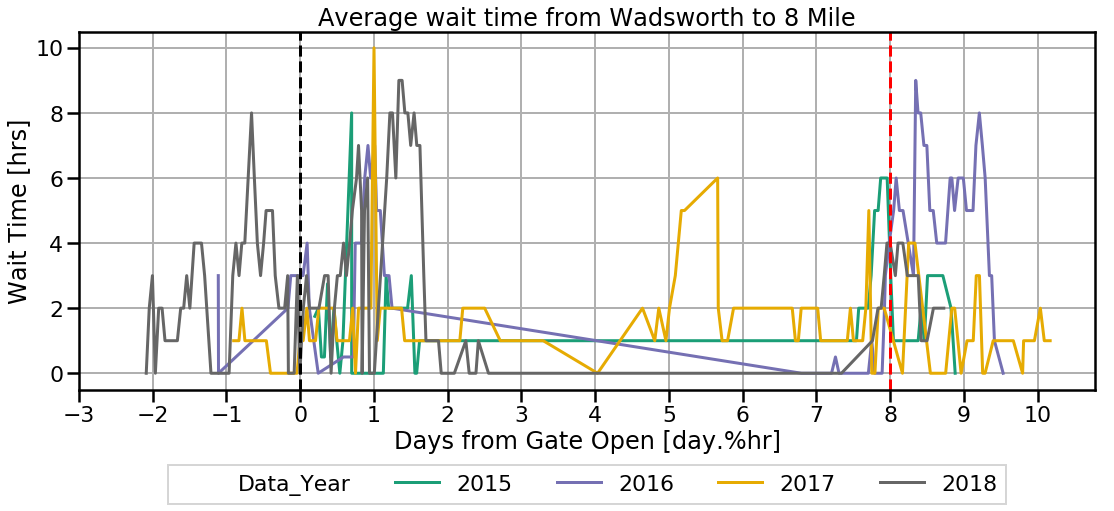

In [29]:

# crop
key = np.array(df_traffic['Data_Year'] >= 2015, dtype=bool)
df_plt = df_traffic.loc[key].copy()

# Plot
mode = 'line'

fig, ax = plt.subplots(1, figsize=(16,8))

if mode=='bar':
    sns.barplot(y='Hours Wait', x='ts', hue='Data_Year', data=df_plt, ax=ax)
    ticks = np.arange(2,9)-1
elif mode=='line':
    sns.lineplot(y='Hours Wait', x='ts', hue='Data_Year', data=df_plt, ax=ax, palette='Dark2')
    ticks = np.arange(-3,11)

# tick_labels = ['Thr', 'Fri','Sat','Sun','Mon','Tue','Wed', 'Thr', 'Fri', 'Sat', 'Sun', 'Mon' ]

ax.axvline(0, color='k', linestyle='--')
ax.axvline(8, color='r', linestyle='--')

ax.set_xticks(ticks)
# ax.set_xticklabels(tick_labels)
ax.set_xlabel('Days from Gate Open [day.%hr]')
ax.set_ylabel('Wait Time [hrs]')
ax.grid(which='both', axis='both')
# ax.legend().set_visible(False)
ax.legend(frameon=True, loc='lower center', bbox_to_anchor=(0.5, -.35), ncol=5, fancybox=False)

ax.set_title('Average wait time from Wadsworth to 8 Mile')

plt.tight_layout()

f_fig_fine = Path(os.path.join(os.path.abspath('..'), 'fig_traffic-fine.png'))
fig.savefig(f_fig_fine)

#### Coarse trends

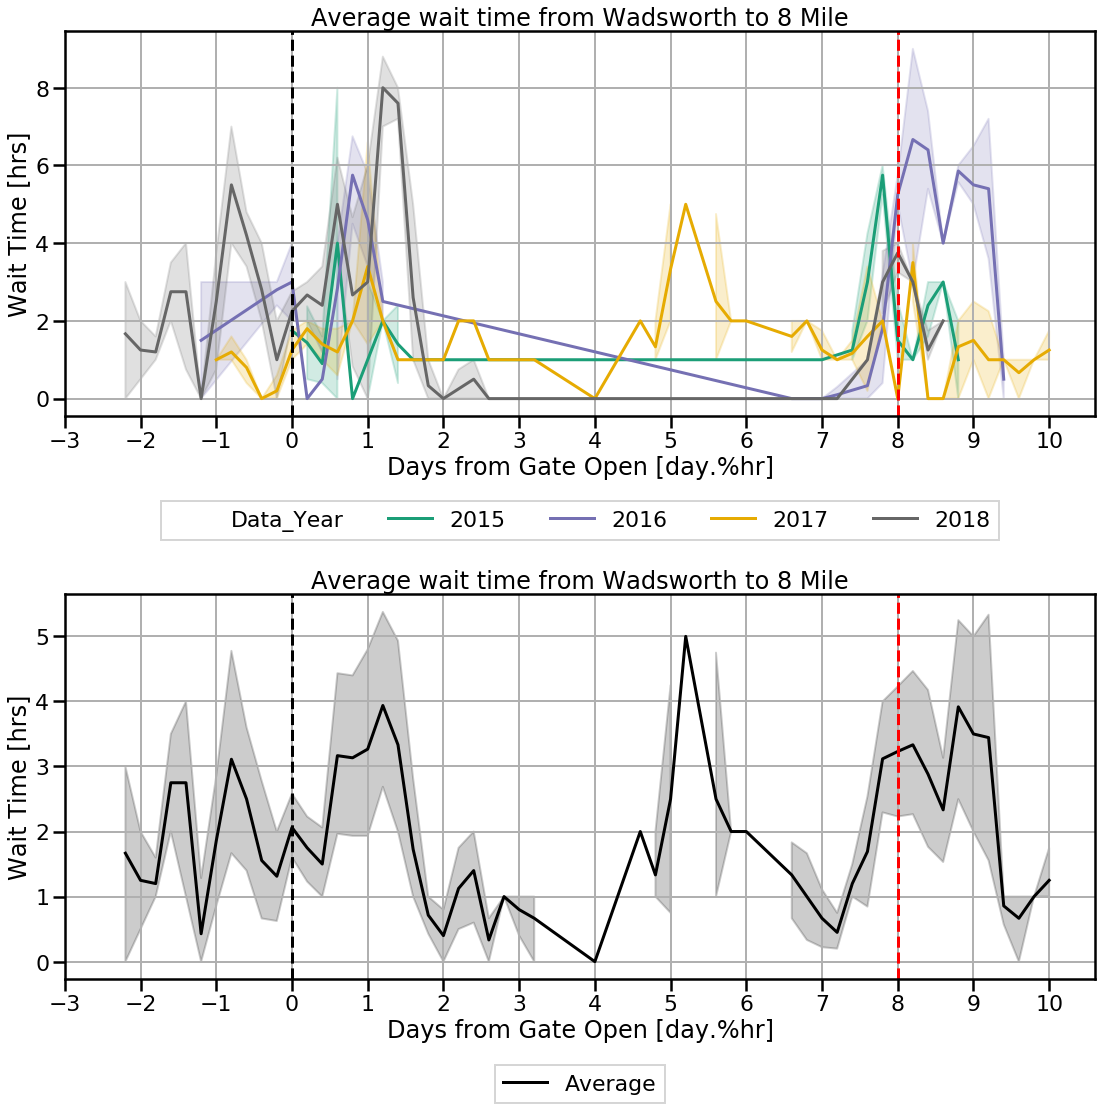

In [30]:

# crop
key = np.array(df_traffic['Data_Year'] >= 2015, dtype=bool)
df_plt = df_traffic.loc[key].copy()

# Plot

fig, axs = plt.subplots(2,1, figsize=(16,16))

sns.lineplot(y='Hours Wait', x='ts_coarse', hue='Data_Year', data=df_plt, ax=axs[0], palette='Dark2')
sns.lineplot(y='Hours Wait', x='ts_coarse', data=df_plt, ax=axs[1], color='k', label='Average')
ticks = np.arange(-3,11)

# tick_labels = ['Thr', 'Fri','Sat','Sun','Mon','Tue','Wed', 'Thr', 'Fri', 'Sat', 'Sun', 'Mon' ]


for ax in axs:
    ax.axvline(0, color='k', linestyle='--')
    ax.axvline(8, color='r', linestyle='--')

    ax.set_xticks(ticks)
    # ax.set_xticklabels(tick_labels)
    ax.set_xlabel('Days from Gate Open [day.%hr]')
    ax.set_ylabel('Wait Time [hrs]')
    ax.grid(which='both', axis='both')
    # ax.legend(frameon=True)
    ax.legend(frameon=True, loc='lower center', bbox_to_anchor=(0.5, -.35),
          ncol=6, fancybox=False)
    
    ax.set_title('Average wait time from Wadsworth to 8 Mile')
plt.tight_layout()

f_fig_coarse = Path(os.path.join(os.path.abspath('..'), 'fig_traffic-coarse.png'))
fig.savefig(f_fig_coarse)